<a href="https://colab.research.google.com/github/zehgobbes/Dive-in-Deep-Learning/blob/main/Fashion_ResNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install time
!pip install torch
!pip install torchvision
!pip install d2l

loss 0.119, train acc 0.956, test acc 0.927
1504.1 examples/sec on [device(type='cuda', index=0)]


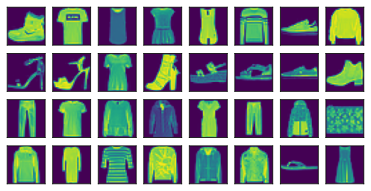

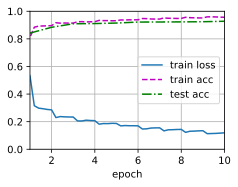

In [1]:
import torch
import torchvision
from torch import nn
from d2l import torch as d2l


all_images = torchvision.datasets.FashionMNIST(train=True, root="../data",
                                          download=True)
d2l.show_images([all_images[i][0] for i in range(32)], 4, 8, scale=0.8);


train_augs = torchvision.transforms.Compose([
     torchvision.transforms.RandomHorizontalFlip(),
     torchvision.transforms.ToTensor()])

test_augs = torchvision.transforms.Compose([
     torchvision.transforms.ToTensor()])



def load_fashion(is_train, augs, batch_size):
    dataset = torchvision.datasets.FashionMNIST(root="../data", train=is_train,
                                           transform=augs, download=True)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                    shuffle=is_train, num_workers=d2l.get_dataloader_workers())
    return dataloader



#-------------------------------------------

#14.1.2.1. Treinamento Multi-GPU
def train_batch_ch13(net, X, y, loss, trainer, devices):
    """Train for a minibatch with multiple GPUs (defined in Chapter 13)."""
    if isinstance(X, list):
        # Required for BERT fine-tuning (to be covered later)
        X = [x.to(devices[0]) for x in X]
    else:
        X = X.to(devices[0])
    y = y.to(devices[0])
    net.train()
    trainer.zero_grad()
    pred = net(X)
    l = loss(pred, y)
    l.sum().backward()
    trainer.step()
    train_loss_sum = l.sum()
    train_acc_sum = d2l.accuracy(pred, y)
    return train_loss_sum, train_acc_sum

#@save
def train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs,
               devices=d2l.try_all_gpus()):
    """Train a model with multiple GPUs (defined in Chapter 13)."""
    timer, num_batches = d2l.Timer(), len(train_iter)
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0, 1],
                            legend=['train loss', 'train acc', 'test acc'])
    net = nn.DataParallel(net, device_ids=devices).to(devices[0])
    for epoch in range(num_epochs):
        # Sum of training loss, sum of training accuracy, no. of examples,
        # no. of predictions
        metric = d2l.Accumulator(4)
        for i, (features, labels) in enumerate(train_iter):
            timer.start()
            l, acc = train_batch_ch13(
                net, features, labels, loss, trainer, devices)
            metric.add(l, acc, labels.shape[0], labels.numel())
            timer.stop()
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (metric[0] / metric[2], metric[1] / metric[3],
                              None))
        test_acc = d2l.evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss {metric[0] / metric[2]:.3f}, train acc '
          f'{metric[1] / metric[3]:.3f}, test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec on '
          f'{str(devices)}')

#-------------------------------------------

# net = modified ResNet-18 model.
batch_size, devices, net = 256, d2l.try_all_gpus(), d2l.resnet18(10, 1)
net.apply(d2l.init_cnn)

def train_with_data_aug(train_augs, test_augs, net, lr=0.001):
    train_iter = load_fashion(True, train_augs, batch_size)
    test_iter = load_fashion(False, test_augs, batch_size)
    loss = nn.CrossEntropyLoss(reduction="none")
    trainer = torch.optim.Adam(net.parameters(), lr=lr)
    net(next(iter(train_iter))[0])
    train_ch13(net, train_iter, test_iter, loss, trainer, 10, devices)

#-------------------------------------------
#
train_with_data_aug(train_augs, test_augs, net)



In [2]:
# -----------------------------------------------------------------------------------------------------
# SALVA PARÂMETROS TREINADOS
torch.save(net.state_dict(), 'FASHION.params')                    # salva todos os parâmetros do modelo treinado.
 #  EXTENSÃO PARA PARÂMETROS: .params

[(name, param.shape) for name, param in net.named_parameters()]   # nomes dos parâmetros


[('0.weight', torch.Size([64, 1, 3, 3])),
 ('0.bias', torch.Size([64])),
 ('1.weight', torch.Size([64])),
 ('1.bias', torch.Size([64])),
 ('resnet_block1.0.conv1.weight', torch.Size([64, 64, 3, 3])),
 ('resnet_block1.0.conv1.bias', torch.Size([64])),
 ('resnet_block1.0.conv2.weight', torch.Size([64, 64, 3, 3])),
 ('resnet_block1.0.conv2.bias', torch.Size([64])),
 ('resnet_block1.0.bn1.weight', torch.Size([64])),
 ('resnet_block1.0.bn1.bias', torch.Size([64])),
 ('resnet_block1.0.bn2.weight', torch.Size([64])),
 ('resnet_block1.0.bn2.bias', torch.Size([64])),
 ('resnet_block1.1.conv1.weight', torch.Size([64, 64, 3, 3])),
 ('resnet_block1.1.conv1.bias', torch.Size([64])),
 ('resnet_block1.1.conv2.weight', torch.Size([64, 64, 3, 3])),
 ('resnet_block1.1.conv2.bias', torch.Size([64])),
 ('resnet_block1.1.bn1.weight', torch.Size([64])),
 ('resnet_block1.1.bn1.bias', torch.Size([64])),
 ('resnet_block1.1.bn2.weight', torch.Size([64])),
 ('resnet_block1.1.bn2.bias', torch.Size([64])),
 ('resn

In [8]:
# data = torch.from_numpy(all_images.data)
# data2 = data.reshape(50000,3,32,32)
data = all_images.data
data.shape

torch.Size([60000, 28, 28])

In [11]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
device = get_default_device()              # dispositivo utilizado

# Transfere 'data' para 'device'
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

val2 = to_device(data, device)                     # transfere os dados de validação (data.val.data) da cpu para a gpu
y_hat = net(val2.type(torch.float32).unsqueeze(dim=1))
print(y_hat)

targets2 = to_device(all_images.targets, device)                     # transfere os dados de targets (data.val.targets) da cpu para a gpu
print(f'acc: {net.accuracy(y_hat,targets2).item():.2f}')
# ------------------------------------------------------------------------------------



OutOfMemoryError: CUDA out of memory. Tried to allocate 11.22 GiB. GPU 